## Load in the data
    Since the data is a .db, which is a sqlite database. We will convert the tables to pandas dataframe as required. Since the table sizes arent too big we can use pandas dataframes.

In [4]:
import sqlite3
import pandas as pd

In [8]:
# Read sqlite query results into a pandas DataFrame
sql_conn = sqlite3.connect("sqlite.db")
exec_df = pd.read_sql_query("SELECT * from exec", sql_conn)
sql_conn.close()

In [9]:
exec_df.head()

,ts,exe,pid,ppid,path,docker,depth,rates
0,0.690,sh,28531,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.2}"
1,0.696,lpstat,28532,28531,/usr/bin/lpstat,None,-1,"{""1"": 2.0, ""5"": 0.4}"
2,0.701,sed,28533,28531,/bin/sed,None,-1,"{""1"": 3.0, ""5"": 0.6}"
3,1.704,sh,28534,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.8}"
4,1.711,sed,28536,28534,sed,None,-1,"{""1"": 2.0, ""5"": 1.0}"


In [15]:
exec_df[exec_df.docker.notnull()].head()

,ts,exe,pid,ppid,path,docker,depth,rates
82,22.574,crawl.sh,28647,28628,/webcrawl/crawl.sh,/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,5,"{""1"": 1.0, ""5"": 0.2}"
83,22.604,python,28668,28647,python,/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,5,"{""1"": 2.0, ""5"": 0.4}"
84,22.936,python,28669,28647,/usr/bin/python,/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,5,"{""1"": 3.0, ""5"": 0.6}"
88,23.374,python,28673,28647,/usr/bin/python,/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,5,"{""1"": 4.0, ""5"": 0.8}"
92,24.167,python,28679,28647,/usr/bin/python,/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,5,"{""1"": 2.0, ""5"": 1.0}"


We need to split the json in rate column into two seperate columns, 'rate1s' and 'rate5s'.
    1. Use rates column to create a dataframe of 2 columns 'rate1s', 'rate5s'.
    2. Concat the dataframe from step 1 with exec_df to get the final clean dtaframe.

In [22]:
# Split rates column into two columns
rates_df = exec_df['rates'].apply(lambda x : dict(eval(x)) ).apply(pd.Series)
rates_df.columns = ['rate1s', 'rate5s']

In [23]:
rates_df.head()

,rate1s,rate5s
0,1.0,0.2
1,2.0,0.4
2,3.0,0.6
3,1.0,0.8
4,2.0,1.0


In [24]:
# Concat this with exec_df to get the entire dataset
exec_clean = pd.concat([exec_df, rates_df], axis=1)

In [25]:
exec_clean.head()

,ts,exe,pid,ppid,path,docker,depth,rates,rate1s,rate5s
0,0.690,sh,28531,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.2}",1.0,0.2
1,0.696,lpstat,28532,28531,/usr/bin/lpstat,None,-1,"{""1"": 2.0, ""5"": 0.4}",2.0,0.4
2,0.701,sed,28533,28531,/bin/sed,None,-1,"{""1"": 3.0, ""5"": 0.6}",3.0,0.6
3,1.704,sh,28534,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.8}",1.0,0.8
4,1.711,sed,28536,28534,sed,None,-1,"{""1"": 2.0, ""5"": 1.0}",2.0,1.0


# 1. Visualization
    We start of with visualizing our data. Visualization can provide a holistic view of our data, helping us further our understanding of the dataset.
    
    Start of with importing visualization libraries

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

## Plot depth
    What is depth? 
    What is rate1s?
    What is rate5s?

In [26]:
# Numerical distribution of depth
exec_clean['depth'].value_counts()

-1    1709
 5     790
 2       2
 3       1
 4       1
Name: depth, dtype: int64

Looking at the distribution of the data, we can see that this type of data can be easily visualized using a scatter plot

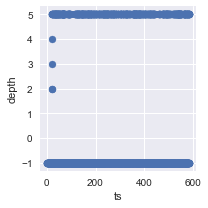

In [40]:
g = sns.FacetGrid(exec_clean)  
g.map(plt.scatter, "ts", "depth")  